# 1-1 学習済みのVGGモデルを使用する方法

# pytorchenvの環境でやってます。

In [2]:
#パッケージのインポート
import numpy as np
import json #jsonって何
from PIL import Image #これも何
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import models,transforms

In [3]:
#Pytorchのバージョン管理
print("PyTorch Version:", torch.__version__)
print("PyTorchvision Version", torchvision.__version__ )

PyTorch Version: 1.1.0
PyTorchvision Version 0.2.2


In [4]:
#学習済みのVGG-16モデルをロード

#VGG-16モデルのインスタンスを生成
use_pretrained=True #学習済みのパラメータを使用
net=models.vgg16(pretrained=use_pretrained)
net.eval() #推論モードに設定

#モデルのネットワーク構成を出力
print(net)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/kawadatakeshiho/.cache/torch/checkpoints/vgg16-397923af.pth
100.0%


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [5]:
#入力画像の前処理のクラス
class BaseTransform():
    """
    画像サイズをリサイズして色を標準化。

    Attributes:
     resize: int  
           リサイズ先の画像の大きさ
     mean :(R,G,B)
           各色チャンネルの平均値
     std: (R,G,B)
           各色チャンネルの標準偏差
    """

    def __init__(self,resize,mean,std):
        self.base_transform=transforms.Compose([
            transforms.Resize(resize), #短い辺の長さがresizeの大きさになる
            transforms.CenterCrop(resize), #画像の中央をresize*resizeで切り取り
            transforms.ToTensor(), #Torchテンソルに変換
            transforms.Normalize(mean,std)
        ])

    def __call__(self,img):
        return self.base_transform(img)
        

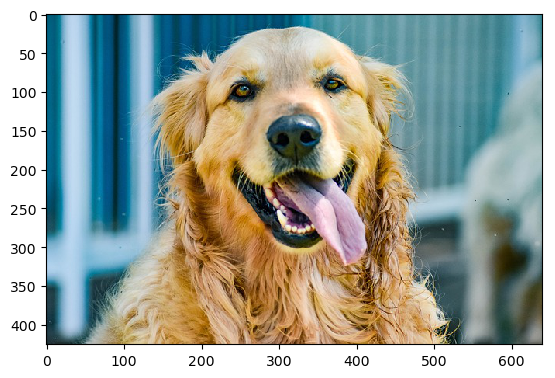

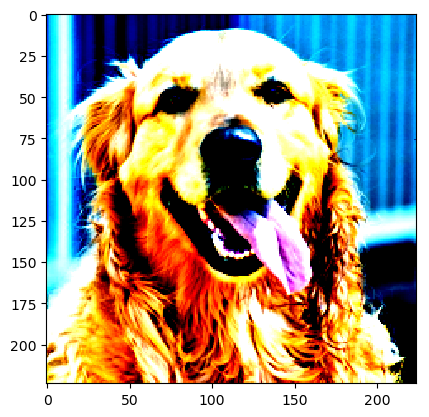

In [19]:
#画像前処理の動作を確認

#1.画像の読み込み
image_file_path="../1_image_classification/data/goldenretriever-3724972_640.jpg"
img=Image.open(image_file_path)

#2.元の画像を表示
plt.imshow(img)
plt.show()

#3.画像の前処理と処理済み画像の表示
resize=224
mean=(0.485,0.456,0.406)
std=(0.229,0.224,0.225)
transform=BaseTransform(resize,mean,std)
img_transformed=transform(img)



#(色、高さ、幅)を(高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed=img_transformed.numpy().transpose((1,2,0))
img_transformed=np.clip(img_transformed,0,1)
plt.imshow(img_transformed)
plt.show()

## 出力結果からラベルを予測する後処理クラスを作成

In [5]:
import json

In [7]:
#ILSVRCのラベル情報をロードし辞書型変数を生成します
ILSVRC_class_index=json.load(open("../1_image_classification/data/imagenet_class_index.json", "r"))
ILSVRC_class_index

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [8]:
#出力結果からラベルを予測する後処理クラス
class ILSVRCPredictor():
    """
    ILSVRCデータに対するモデルの出力からラベルを求める

    Attributes
    -----------
    class_index : dictionary
                  クラスindexとラベル名を対応させた辞書型変数
    
    """

    def __init__(self,class_index):
        self.class_index=class_index
    
    def predict_max(self,out):
        """
        確率最大のILSVRCのラベル名を取得する。
        Parameters
        ---------------
        out : torch.Size([1,1000])
           Netからの出力。

        Returns
        ---------------
        predicted_label_name : str
           最も予測確率が高いラベルの名前

        """
        maxid=np.argmax(out.detach.numpy())
        predicted_label_name=self.class_index[str(maxid)][1]

        return predicted_label_name

In [13]:
ILSVRC_class_index["0"]

['n01440764', 'tench']

## 学習済みVGGモデルで手元の画像を予測

In [ ]:
#ILSVRCのラベル情報をロードし辞書型変数を生成
ILSVRC_class_index=json.load(open("../1_image_classification/data/imagenet_class_index.json", "r"))

#ILSVRCPredivtoreのインスタンスを生成
predictor=ILSVRCPredictor(ILSVRC_class_index)

#入力画像を読み込む
image_file_path="../1_image_classification/data/goldenretriever-3724972_640.jpg"
img=Image.open(image_file_path)  #[高さ][幅][色RGB]

#前処理の後、バッチサイズの次元を追加する
transform=BaseTransform(resize, mean,std) #前処理クラスを生成
img_transformed=transform(img) #torch.Size([3,224,224])
inputs=img_transformed.unsqueeze_(0) #torcg.Size([1,3,224,224])

#モデルに入力し、モデル出力をラベルに変換する
out=net(inputs) #torch.Size([1,1000])
result=predictor.predict_max(out)

#予測結果を出力する
print("入力画像の予測結果：", result)